In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import matplotlib
import copy
import cv2
# matplotlib.font_manager._rebuild()
# plt.rcParams['font.family'] = 'Times New Roman' #全体のフォントを設定
%matplotlib inline

In [2]:
import sys
sys.path.append("/notebooks/nb_IEEE/opmap/")

In [3]:
import opmap
from opmap.rawCam import RawCam
from opmap.vmemMap import VmemMap
from opmap.apdMap import APDMap
from opmap.phaseMapHilbert import PhaseMapHilbert as PhaseMap
from opmap.phaseVarianceMap import PhaseVarianceMap

In [4]:
def FFT(vmem_1d, N, dt, fc_low=None, fc_high=None):
    fq = np.linspace(0, 1.0/dt, N)
    F = np.fft.fft(vmem_1d)
    if fc_low is not None:
        F[(fq <= fc_low)] = 0
    if fc_high is not None:
        F[(fq >= fc_high)] = 0
    
    F_abs = np.abs(F)
    F_abs_amp = F_abs/N
#     F_abs_amp[0] = F_abs_amp[0]/2
    F_abs_amp[0] = 0
    
    F_ifft = np.fft.ifft(F)
    F_ifft_real = F_ifft.real * 2
    
    return F_ifft_real

In [5]:
def isochronal(pmap, threshold):
    contour = np.zeros_like(pmap.data)

    for i in range(contour.shape[1]):
        for j in range(contour.shape[2]):        
            if pmap.roi[i,j] == 1:
                counter = 0
                for time in range(contour.shape[0]):
                    if time == 0:
                        pass
                    elif ((pmap.data[time-1, i, j] < threshold) * (pmap.data[time, i, j] > threshold)) == 1:
                        counter = 0

                    contour[time, i, j] = counter
                    counter += 1
                
    return contour

In [14]:
def normalize(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

## 旋回興奮 APD50

In [130]:
analysis_path = [["/mnt/Jalife/ExperimentData/20181121-1/C001H001S0008/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0014.png"],
                 ["/mnt/Jalife/ExperimentData/20181121-1/C001H001S0014/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0014.png"],
                 ["/mnt/Jalife/ExperimentData/20181121-1/C001H001S0017/", 21500, 22500,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0017.png"],
                 ["/mnt/Jalife/ExperimentData/20181121-1/C001H001S0021/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0017.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0007/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0007.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0008/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0007.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0009/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0009.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0011/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0009.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0017/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0009.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0018/", 24200, 25200,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0020/", 6700, 7700,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0022/", 25700, 26700,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0024/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0026/", 29500, 30500,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0028/", 21000, 22000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0007/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0007.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0009/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0007.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0010/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0012.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0012/", 9500, 10500,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0012.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0014/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0012.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0015/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0020.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0018/", 10000, 11000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0020.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0020/", 7300, 8300,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0020.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0022/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0020.png"]
                ]

In [168]:
for analysis_info in analysis_path:
    data_path = analysis_info[0]
    print(data_path)
    
    start = analysis_info[1]
    end = analysis_info[2]
    
    date = data_path.split('/')[-3]
    session_name = data_path.split('/')[-2]
    save_path = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', 'APD50/%s/%s/%s-%s' % (date, session_name, start, end))
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    raw = RawCam(path=data_path, cam_type='sa4',image_width=256, image_height=256, frame_start=start, frame_end=end)
    vmem = VmemMap(raw)
    
    roi_png = cv2.imread(analysis_info[3], cv2.IMREAD_GRAYSCALE)
    roi_png = roi_png/255.0
    
    vmem.roi = roi_png
    vmem.data = vmem.data * vmem.roi
    
    for i in range(vmem.data.shape[1]):
        for j in range(vmem.data.shape[2]):
            vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)
            
    vmem.smooth(size=9)
    
    apd = APDMap(vmem, max_beats=5, thre_up=0.9, thre_down=0.5)
    
    for i in range(5):
        plt.imshow(apd.data[i]*2, vmin=0, vmax=100, cmap="viridis")
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        plt.savefig(os.path.join(save_path, "%s.png"%i))
        plt.close()

/mnt/Jalife/ExperimentData/20181121-1/C001H001S0008/
/mnt/Jalife/ExperimentData/20181121-1/C001H001S0014/
/mnt/Jalife/ExperimentData/20181121-1/C001H001S0017/
/mnt/Jalife/ExperimentData/20181121-1/C001H001S0021/
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0007/
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0008/
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0009/
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0011/
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0017/
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0018/
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0020/
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0022/
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0024/
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0026/
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0028/
/mnt/Jalife/ExperimentData/20181220-1/C001H001S0007/
/mnt/Jalife/ExperimentData/20181220-1/C001H001S0009/
/mnt/Jalife/ExperimentData/20181220-1/C001H001S0010/
/mnt/Jalife/ExperimentData/20181220-1/C001H001

### 20181121-1/C001H001S0008

In [94]:
data_name = '20181121-1/C001H001S0008/'
parent_path = '/mnt/Jalife/ExperimentData/'

data_path = os.path.join(parent_path, data_name)
print(data_path)

start = 29000
end = 30000

date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', '%s/%s/%s-%s' % (date, session_name, start, end))

raw = RawCam(path=data_path, cam_type='sa4',image_width=256, image_height=256, frame_start=start, frame_end=end)

vmem = VmemMap(raw)

roi_png = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0014.png', cv2.IMREAD_GRAYSCALE)
roi_png = roi_png/255.0

vmem.roi = roi_png
vmem.data = vmem.data * vmem.roi

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)

vmem.smooth(size=9)

/mnt/Jalife/ExperimentData/20181121-1/C001H001S0008/


In [139]:
apd = APDMap(vmem, max_beats=15, thre_up=0.7, thre_down=0.5)

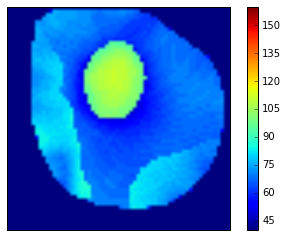

In [141]:
plt.imshow(apd.data[3]*2, vmin=40, vmax=160)
plt.xticks([])
plt.yticks([])
plt.colorbar()

### 20181121-1/C001H001S0017

In [145]:
data_name = '20181121-1/C001H001S0017/'
parent_path = '/mnt/Jalife/ExperimentData/'

data_path = os.path.join(parent_path, data_name)
print(data_path)

start = 21500
end = 22500

date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', '%s/%s/%s-%s' % (date, session_name, start, end))

raw = RawCam(path=data_path, cam_type='sa4',image_width=256, image_height=256, frame_start=start, frame_end=end)

vmem = VmemMap(raw)

roi_png = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0017.png', cv2.IMREAD_GRAYSCALE)
roi_png = roi_png/255.0

vmem.roi = roi_png
vmem.data = vmem.data * vmem.roi

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)

vmem.smooth(size=9)

/mnt/Jalife/ExperimentData/20181121-1/C001H001S0017/


In [156]:
apd = APDMap(vmem, max_beats=5, thre_up=0.9, thre_down=0.5)

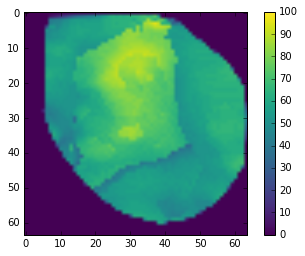

In [166]:
plt.imshow(apd.data[1]*2, vmin=0, vmax=100, cmap="viridis")
# plt.imshow(apd.data[1]*2, vmin=0, vmax=100)
plt.colorbar()

In [159]:
np.unique(apd.data[1])

array([  0.        ,   0.08627451,   0.12156863,   0.27058825,
         0.45490196,   1.03529418,   1.52941179,   1.86666667,
         2.04705882,   2.0666666 ,   2.58823538,   3.5999999 ,
         4.        ,   4.55294132,   4.91764688,   5.34901953,
         5.5999999 ,   6.44313717,   6.92941189,   7.02745104,
         7.33333349,   9.16078472,   9.19999981,  10.88235283,
        11.04313755,  11.05882359,  11.30196095,  11.66666698,
        11.67058849,  12.        ,  13.07843113,  13.86666679,
        14.49411774,  15.        ,  15.05882359,  15.60000038,
        16.        ,  16.20000076,  16.49019623,  17.        ,
        17.08235359,  18.        ,  18.63529396,  18.66666603,
        18.91764641,  18.94902039,  19.        ,  19.07451057,
        19.0862751 ,  19.33333397,  19.38823509,  19.79999924,
        20.        ,  21.        ,  21.03921509,  21.45882416,
        21.49411774,  21.60000038,  22.        ,  22.1764698 ,
        23.        ,  23.34117699,  23.62352943,  23.71

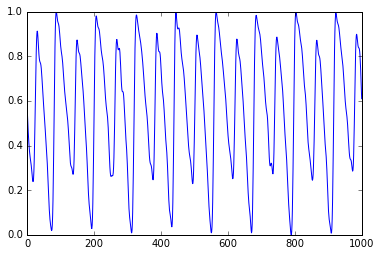

In [68]:
plt.plot(normalize(vmem.data[:, 160, 150]))

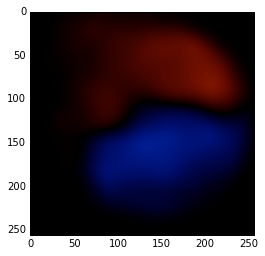

In [60]:
vmem.showFrame(310)

In [57]:
APD50 = np.zeros((256,256))

for i in range(256):
    for j in range(256):
        
        flag = 0
        start = 0
        end = 0
        
        if vmem.roi[i,j] == 0:
            pass
        else:
            for t in range(100):
                if flag == 0 and normalize(vmem.data[170:270,i,j])[t] > 0.5 and start == 0:
                    flag = 1
                    start = t
                if flag == 1 and normalize(vmem.data[170:270,i,j])[t] > 0.7:
                    flag = 2
                if flag == 2 and normalize(vmem.data[170:270,i,j])[t] < 0.5 and end == 0:
                    flag = 3
                    end = t
            APD50[i,j] = (end-start)*2

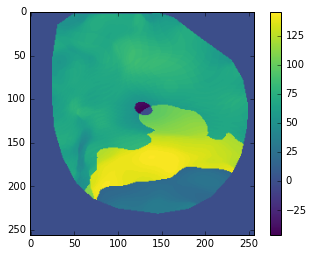

In [66]:
plt.imshow(APD50, vmin=40, vmax=140, cmap="viridis")
plt.imshow(APD50, cmap="viridis")
# plt.xticks([])
# plt.yticks([])
plt.colorbar()
# plt.savefig("/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/APD50/20181121-1_C001H001S0017.png")
# plt.close()

### 20181121-1/C001H001S0021

### 20181121-1/C001H001S0008

In [19]:
data_name = '20181121-1/C001H001S0008/'
parent_path = '/mnt/Jalife/ExperimentData/'

data_path = os.path.join(parent_path, data_name)
print(data_path)

start = 29000
end = 30000

date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', '%s/%s/%s-%s' % (date, session_name, start, end))

raw = RawCam(path=data_path, cam_type='sa4',image_width=256, image_height=256, frame_start=start, frame_end=end)

vmem = VmemMap(raw)

roi_png = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0014.png', cv2.IMREAD_GRAYSCALE)
roi_png = roi_png/255.0

vmem.roi = roi_png
vmem.data = vmem.data * vmem.roi

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)

vmem.smooth(size=9)

/mnt/Jalife/ExperimentData/20181121-1/C001H001S0008/


### transparent phase variance

In [14]:
from PIL import Image

im_rgb = Image.open('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/trajectory.png')
im_rgba = im_rgb.copy()
im_rgba.putalpha(128)
im_data = np.array(im_rgba)

for i in range(128):
    for j in range(128):
        if im_data[i,j,0] < 128:
            im_data[i,j,3] = 0
        else:
            im_data[i,j,3] = 255

plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/gray/alpha_pvmap.png',
       im_data, cmap='gray')
plt.close()

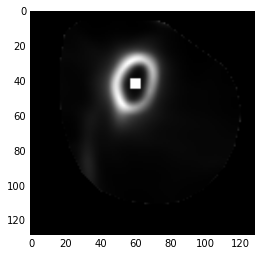

In [22]:
img = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/trajectory.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img[39:45, 57:63] = 255
plt.imshow(img)

In [35]:
img = np.zeros((256, 256, 4))

img[41:47, 97:103, :] = 1
img[61:67, 107:113, :] = 1
img[81:87, 117:123, :] = 1
img[101:107, 127:133, :] = 1
img[121:127, 137:143, :] = 1

plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/gray/vmem_point2.png',
           img, cmap='gray')
plt.close()

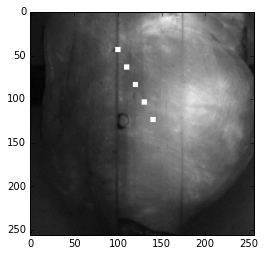

In [24]:
num = 305
#img = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/jet/vmem/%s.png'%'{0:06d}'.format(num))
img = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/jet/raw/000001.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
#中心
# img[59:63,39:43] = 0

img[41:47, 97:103] = 255
img[61:67, 107:113] = 255
img[81:87, 117:123] = 255
img[101:107, 127:133] = 255
img[121:127, 137:143] = 255

# img[27:33,134:140] = 255
# img[47:53,134:140] = 255
# img[67:73,134:140] = 255
# img[87:93,134:140] = 255


# img[22:24,70:72] = 0
# img[41:43,73:75] = 0
# img[52:54,57:59] = 0
# img[44:46,40:42] = 0
# img[25:27,37:39] = 0
# img[14:16,53:55] = 0

#plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-10500/jet/vmem_%s.png'%num, img)

In [49]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(hspace=0.3) 

plt.subplot(5,1,1)
# plt.plot(normilize(vmem.data[845:915, 156, 108]))
plt.plot(normilize(vmem.data[110:240, 44, 100]))
plt.xlim([0, 130])
plt.xticks([])
plt.yticks([])
# plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.subplot(5,1,2)
# plt.plot(normilize(vmem.data[845:915, 156, 58]))
plt.plot(normilize(vmem.data[110:240, 64, 110]))
plt.xlim([0, 130])
plt.xticks([])
plt.yticks([])
# plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.subplot(5,1,3)
# plt.plot(normilize(vmem.data[845:915, 110, 42]))
plt.plot(normilize(vmem.data[110:240, 84, 120]))
plt.xlim([0, 130])
plt.xticks([])
plt.yticks([])
# plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.subplot(5,1,4)
# plt.plot(normilize(vmem.data[845:915, 80, 82]))
plt.plot(normilize(vmem.data[110:240, 104, 130]))
plt.xlim([0, 130])
plt.xticks([])
plt.yticks([])
# plt.xticks([0, 10, 20, 30, 40, 50, 60], [850, 860, 870, 880, 890, 900, 910])
# plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.subplot(5,1,5)
# plt.plot(normilize(vmem.data[845:915, 108, 122]))
plt.plot(normilize(vmem.data[110:240, 124, 140]))
plt.xlim([0, 130])
plt.xticks([0, 40, 80, 120], [58.00, 58.08, 58.16, 58.24], size=20)
plt.yticks([])
# plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/gray/vmem_plot2.png',
            dpi=300, transparent=True)
plt.close()

In [235]:
APD50 = np.zeros((256,256))

for i in range(256):
    for j in range(256):
        
        flag = 0
        start = 0
        end = 0
        
        if vmem.roi[i,j] == 0:
            pass
        else:
            for t in range(100):
                if flag == 0 and normirize(vmem.data[100:200,i,j])[t] > 0.5 and start == 0:
                    flag = 1
                    start = t
                if flag == 1 and normirize(vmem.data[100:200,i,j])[t] > 0.7:
                    flag = 2
                if flag == 2 and normirize(vmem.data[100:200,i,j])[t] < 0.5 and end == 0:
                    flag = 3
                    end = t
            APD50[i,j] = (end-start)*2

In [226]:
plt.imshow(APD50, vmin=40, vmax=140, cmap='viridis')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.savefig("/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/APD50/20181121-1_C001H001S0008.png")
plt.close()

In [228]:
plt.imsave("/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/APD50/20181121-1_C001H001S0008_wocolorbar.png", APD50, cmap="viridis", vmin=40, vmax=140)

### 20181121-1/C001H001S0017

In [229]:
data_name = '20181121-1/C001H001S0017/'
parent_path = '/mnt/Jalife/ExperimentData/'

data_path = os.path.join(parent_path, data_name)
print(data_path)

start = 21500
end = 22500

date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', '%s/%s/%s-%s' % (date, session_name, start, end))

raw = RawCam(path=data_path, cam_type='sa4',
          image_width=256, image_height=256, frame_start=start, frame_end=end)

vmem = VmemMap(raw)

roi_png = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0017.png', cv2.IMREAD_GRAYSCALE)
roi_png = roi_png/255.0

vmem.roi = roi_png
vmem.data = vmem.data * vmem.roi

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)

vmem.smooth(size=9)

/mnt/Jalife/ExperimentData/20181121-1/C001H001S0017/


In [130]:
raw.saveImage(os.path.join(save_parent, "jet/raw"), skip=500)

In [116]:
vmem.saveImage(os.path.join(save_parent, "jet/vmem"))

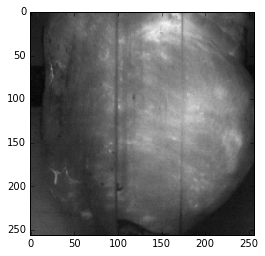

In [169]:
num = 350
#img = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0017/21500-22500/jet/vmem/%s.png'%'{0:06d}'.format(num))
img = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0017/21500-22500/jet/raw/000001.png')

#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
#中心
# img[59:63,39:43] = 0

#img[7:13,134:140] = 255
#img[27:33,134:140] = 255
#img[47:53,134:140] = 255
#img[67:73,134:140] = 255
#img[87:93,134:140] = 255

# img[22:24,70:72] = 0
# img[41:43,73:75] = 0
# img[52:54,57:59] = 0
# img[44:46,40:42] = 0
# img[25:27,37:39] = 0
# img[14:16,53:55] = 0

#plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-10500/jet/vmem_%s.png'%num, img)

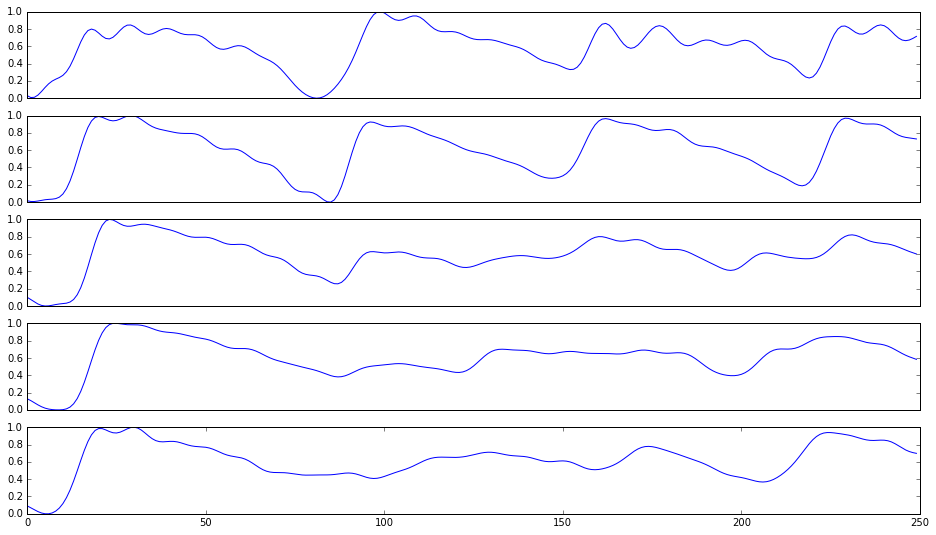

In [129]:
duration = 140

plt.figure(figsize=(16,9))
plt.subplot(5,1,1)
plt.plot(normirize(vmem.data[115:115+duration, 10, 128]))
plt.xticks([])

plt.subplot(5,1,2)
plt.plot(normirize(vmem.data[115:115+duration, 30, 128]))
plt.xticks([])

plt.subplot(5,1,3)
plt.plot(normirize(vmem.data[114:114+duration, 50, 128]))
plt.xticks([])

plt.subplot(5,1,4)
plt.plot(normirize(vmem.data[113:113+duration, 70, 128]))
plt.xticks([])

plt.subplot(5,1,5)
plt.plot(normirize(vmem.data[114:114+duration, 90, 128]))

In [230]:
APD50 = np.zeros((256,256))

for i in range(256):
    for j in range(256):
        
        flag = 0
        start = 0
        end = 0
        
        if vmem.roi[i,j] == 0:
            pass
        else:
            for t in range(100):
                if flag == 0 and normirize(vmem.data[120:220,i,j])[t] > 0.5 and start == 0:
                    flag = 1
                    start = t
                if flag == 1 and normirize(vmem.data[120:220,i,j])[t] > 0.7:
                    flag = 2
                if flag == 2 and normirize(vmem.data[120:220,i,j])[t] < 0.5 and end == 0:
                    flag = 3
                    end = t
            APD50[i,j] = (end-start)*2

In [231]:
plt.imshow(APD50, vmin=40, vmax=140, cmap="viridis")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.savefig("/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/APD50/20181121-1_C001H001S0017.png")
plt.close()

In [232]:
plt.imsave("/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/APD50/20181121-1_C001H001S0017_wocolorbar.png", APD50, cmap="viridis", vmin=40, vmax=140)

## batch phase variance analysis

In [51]:
analysis_path = ["/mnt/Jalife/ExperimentData/20181121-1/C001H001S0008/",
                 "/mnt/Jalife/ExperimentData/20181121-1/C001H001S0014/",
                 "/mnt/Jalife/ExperimentData/20181121-1/C001H001S0017/",
                 "/mnt/Jalife/ExperimentData/20181121-1/C001H001S0021/",
                 "/mnt/Jalife/ExperimentData/20181218-1/C001H001S0007/",
                 "/mnt/Jalife/ExperimentData/20181218-1/C001H001S0008/",
                 "/mnt/Jalife/ExperimentData/20181218-1/C001H001S0009/",
                 "/mnt/Jalife/ExperimentData/20181218-1/C001H001S0011/",
                 "/mnt/Jalife/ExperimentData/20181218-1/C001H001S0017/",
                 "/mnt/Jalife/ExperimentData/20181218-1/C001H001S0018/",
                 "/mnt/Jalife/ExperimentData/20181218-1/C001H001S0020/",
                 "/mnt/Jalife/ExperimentData/20181218-1/C001H001S0022/",
                 "/mnt/Jalife/ExperimentData/20181218-1/C001H001S0024/",
                 "/mnt/Jalife/ExperimentData/20181218-1/C001H001S0026/",
                 "/mnt/Jalife/ExperimentData/20181218-1/C001H001S0028/",
                 "/mnt/Jalife/ExperimentData/20181220-1/C001H001S0007/",
                 "/mnt/Jalife/ExperimentData/20181220-1/C001H001S0009/",
                 "/mnt/Jalife/ExperimentData/20181220-1/C001H001S0010/",
                 "/mnt/Jalife/ExperimentData/20181220-1/C001H001S0012/",
                 "/mnt/Jalife/ExperimentData/20181220-1/C001H001S0014/",
                 "/mnt/Jalife/ExperimentData/20181220-1/C001H001S0015/",
                 "/mnt/Jalife/ExperimentData/20181220-1/C001H001S0018/",
                 "/mnt/Jalife/ExperimentData/20181220-1/C001H001S0020/",
                 "/mnt/Jalife/ExperimentData/20181220-1/C001H001S0022/"
                ]

In [62]:
for analysis in analysis_path:
    #print(analysis)
    
    start = 0
    end = 10
    
    date = analysis.split('/')[-3]
    session_name = analysis.split('/')[-2]
    print(date, session_name)
    
    save_name = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/raw', '%s_%s.png' % (date, session_name))
    
    raw = RawCam(path=analysis, cam_type='sa4',
          image_width=256, image_height=256, frame_start=start, frame_end=end)
    
    plt.imsave(save_name, raw.data[5]/np.max(raw.data[5]), vmin=0, vmax=1, cmap='gray')
    plt.close()

20181121-1 C001H001S0008
20181121-1 C001H001S0014
20181121-1 C001H001S0017
20181121-1 C001H001S0021
20181218-1 C001H001S0007
20181218-1 C001H001S0008
20181218-1 C001H001S0009
20181218-1 C001H001S0011
20181218-1 C001H001S0017
20181218-1 C001H001S0018
20181218-1 C001H001S0020
20181218-1 C001H001S0022
20181218-1 C001H001S0024
20181218-1 C001H001S0026
20181218-1 C001H001S0028
20181220-1 C001H001S0007
20181220-1 C001H001S0009
20181220-1 C001H001S0010
20181220-1 C001H001S0012
20181220-1 C001H001S0014
20181220-1 C001H001S0015
20181220-1 C001H001S0018
20181220-1 C001H001S0020
20181220-1 C001H001S0022


In [63]:
analysis_path = [["/mnt/Jalife/ExperimentData/20181121-1/C001H001S0008/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0014.png"],
                 ["/mnt/Jalife/ExperimentData/20181121-1/C001H001S0014/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0014.png"],
                 ["/mnt/Jalife/ExperimentData/20181121-1/C001H001S0017/", 21500, 22500,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0017.png"],
                 ["/mnt/Jalife/ExperimentData/20181121-1/C001H001S0021/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0017.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0007/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0007.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0008/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0007.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0009/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0009.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0011/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0009.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0017/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0009.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0018/", 24200, 25200,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0020/", 6700, 7700,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0022/", 25700, 26700,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0024/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0026/", 29500, 30500,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181218-1/C001H001S0028/", 21000, 22000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181218-1_C001H001S0018.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0007/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0007.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0009/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0007.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0010/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0012.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0012/", 9500, 10500,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0012.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0014/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0012.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0015/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0020.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0018/", 10000, 11000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0020.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0020/", 7300, 8300,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0020.png"],
                 ["/mnt/Jalife/ExperimentData/20181220-1/C001H001S0022/", 29000, 30000,
                  "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181220-1_C001H001S0020.png"]
                ]

In [89]:
for analysis in analysis_path:
    
    data_path = analysis[0]
    start = analysis[1]
    end = analysis[2]
    mask_dir = analysis[3]
    
    date = data_path.split('/')[-3]
    session_name = data_path.split('/')[-2]
    
    print(data_path, start, end)
    print(date, session_name)
    
    raw = RawCam(path=data_path, cam_type='sa4',
          image_width=256, image_height=256, frame_start=start, frame_end=end)
    
    vmem = VmemMap(raw)
    
    roi_png = cv2.imread(mask_dir, cv2.IMREAD_GRAYSCALE)
    roi_png = roi_png/255.0

    vmem.roi = roi_png
    vmem.data = vmem.data * vmem.roi
    
    for i in range(vmem.data.shape[1]):
        for j in range(vmem.data.shape[2]):
            vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)

    vmem.smooth(size=9)
    
    pmap = PhaseMap(vmem)
    pvmap = PhaseVarianceMap(pmap, size=9)
    
    PS = (pvmap.data > 0.8)*1

    plt.imsave(os.path.join("/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/PS_trajectory/", "%s_%s.png" % (date, session_name)),
              np.sum(PS, axis=0), cmap="viridis")
    plt.close()

/mnt/Jalife/ExperimentData/20181121-1/C001H001S0008/ 29000 30000
20181121-1 C001H001S0008
/mnt/Jalife/ExperimentData/20181121-1/C001H001S0014/ 29000 30000
20181121-1 C001H001S0014
/mnt/Jalife/ExperimentData/20181121-1/C001H001S0017/ 21500 22500
20181121-1 C001H001S0017
/mnt/Jalife/ExperimentData/20181121-1/C001H001S0021/ 29000 30000
20181121-1 C001H001S0021
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0007/ 29000 30000
20181218-1 C001H001S0007
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0008/ 29000 30000
20181218-1 C001H001S0008
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0009/ 29000 30000
20181218-1 C001H001S0009
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0011/ 29000 30000
20181218-1 C001H001S0011
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0017/ 29000 30000
20181218-1 C001H001S0017
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0018/ 24200 25200
20181218-1 C001H001S0018
/mnt/Jalife/ExperimentData/20181218-1/C001H001S0020/ 6700 7700
20181218-1 C001H001S0020
/mnt/Jalife/

In [90]:
analysis = ["/mnt/Jalife/ExperimentData/20181121-1/C001H001S0017/", 21500, 22500,
            "/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/mask/20181121-1_C001H001S0017.png"]